# Table of Contents
 <p><div class="lev1"><a href="#Seriation-Classification:--sc-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Seriation Classification:  sc-1</a></div><div class="lev2"><a href="#Initial-Classification-Attempt"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Initial Classification Attempt</a></div><div class="lev2"><a href="#Leave-One-Out-Cross-Validation-for-Selecting-Optimal-K"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Leave-One-Out Cross Validation for Selecting Optimal K</a></div>

# Seriation Classification:  sc-1 #

The goal of experiment `sc-1` is to validate that the Laplacian eigenvalue spectral distance can be useful in k-Nearest Neighbor classifiers for seriation output.  In this experiment, I take a supervised learning approach, starting with two regional metapopulation models, simulating unbiased cultural transmission with 50 replicates across each model, sampling and time averaging the resulting cultural trait distributions in archaeologically realistic ways, and then seriating the results using our IDSS algorithm.  Each seriation resulting from this procedure is thus "labeled" as to the regional metapopulation model from which it originated, so we can assess the accuracy of predicting that label based upon the graph spectral similarity.  

In [2]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import cPickle as pickle
from copy import deepcopy
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
train_graphs = pickle.load(open("train-freq-graphs.pkl",'r'))
train_labels = pickle.load(open("train-freq-labels.pkl",'r'))

sklearn-mmadsen is a python package of useful machine learning tools that I'm accumulating for research and commercial work.  You can find it at http://github.com/mmadsen/sklearn-mmadsen.  

In [4]:
import sklearn_mmadsen.graphs as skm

## Initial Classification Attempt ##

Let's just see if the graph spectral distance does anything useful at all, or whether I'm barking up the wrong tree.  I imagine that we want a few neighbors (to rule out relying on a single neighbor which might be anomalous), but not too many.  So let's start with k=5.  

The approach here is to essentially do a "leave one out" strategy on the dataset.  The KNN model isn't really "trained" in the usual sense of the term, so we don't need to separate a test and train set, we just need to make sure that the target graph we're trying to predict is not one of the "training" graphs that we calculate spectral distances to, otherwise the self-matching of the graph will always predict zero distance.  So we first define a simple function which splits a graph out of the training set and returns the rest.  I'd use scikit-learn functions for this, but our "data" is really a list of NetworkX objects, not a numeric matrix.

In [5]:
gclf = skm.GraphEigenvalueNearestNeighbors(n_neighbors=5)

In [6]:
def leave_one_out_cv(ix, train_graphs, train_labels):
    """
    Simple LOO data sets for kNN classification, given an index, returns a train set, labels, with the left out 
    graph and label as test_graph, test_label
    """
    test_graph = train_graphs[ix]
    test_label = train_labels[ix]
    train_loo_graphs = deepcopy(train_graphs)
    train_loo_labels = deepcopy(train_labels)
    del train_loo_graphs[ix]
    del train_loo_labels[ix]
    return (train_loo_graphs, train_loo_labels, test_graph, test_label)

In [7]:
test_pred = []
for ix in range(0, len(train_graphs)):
    train_loo_graphs, train_loo_labels, test_graph, test_label = leave_one_out_cv(ix, train_graphs, train_labels)
    gclf.fit(train_loo_graphs, train_loo_labels)
    test_pred.append(gclf.predict([test_graph])[0])
    

In [8]:
cm = confusion_matrix(train_labels, test_pred)
cmdf = pd.DataFrame(cm)
cmdf.columns = map(lambda x: 'predicted {}'.format(x), cmdf.columns)
cmdf.index = map(lambda x: 'actual {}'.format(x), cmdf.index)

print cmdf
print(classification_report(train_labels, test_pred))
print("Accuracy on test: %0.3f" % accuracy_score(train_labels, test_pred))

          predicted 0  predicted 1
actual 0           41            9
actual 1           14           35
             precision    recall  f1-score   support

          0       0.75      0.82      0.78        50
          1       0.80      0.71      0.75        49

avg / total       0.77      0.77      0.77        99

Accuracy on test: 0.768


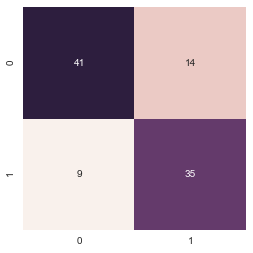

In [9]:
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)

For a first try, this is pretty darned good, I think.  Almost 77% of the time, we can correctly predict whether a seriation solution from one of two models belongs to the correct model.  It would be nice to get that accuracy to near perfect if possible, howeve, because the goal here is to examine the fit between an empirical solution and a number of models, and the empirical solution will **never** have arisen from one of our pure theoretical models.  

## Leave-One-Out Cross Validation for Selecting Optimal K ##

Before working on more complex approaches, let's simply make sure we're choosing the optimal number of neighbors for the k-Nearest Neighbors classifier.  

In [10]:
knn = [1, 3, 5, 7, 9, 11, 15]
for nn in knn:
    gclf = skm.GraphEigenvalueNearestNeighbors(n_neighbors=nn)
    test_pred = []
    for ix in range(0, len(train_graphs)):
        train_loo_graphs, train_loo_labels, test_graph, test_label = leave_one_out_cv(ix, train_graphs, train_labels)
        gclf.fit(train_loo_graphs, train_loo_labels)
        test_pred.append(gclf.predict([test_graph])[0])
    print("Accuracy on test for %s neighbors: %0.3f" % (nn, accuracy_score(train_labels, test_pred)))
    

Accuracy on test for 1 neighbors: 0.788
Accuracy on test for 3 neighbors: 0.798
Accuracy on test for 5 neighbors: 0.768
Accuracy on test for 7 neighbors: 0.747
Accuracy on test for 9 neighbors: 0.758
Accuracy on test for 11 neighbors: 0.788
Accuracy on test for 15 neighbors: 0.788


Clearly, 5 was suboptimal, and the best results (at least on these data) are coming from 3-NN classification.  Almost 80%, in fact!  This is great, but let's see what we can do with a more traditional feature engineering approach and a boosted classifier.  